In [3]:
pip install matplotlib seaborn numpy pandas

Note: you may need to restart the kernel to use updated packages.


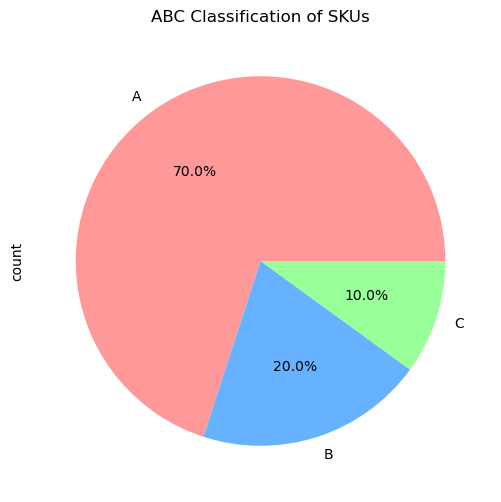

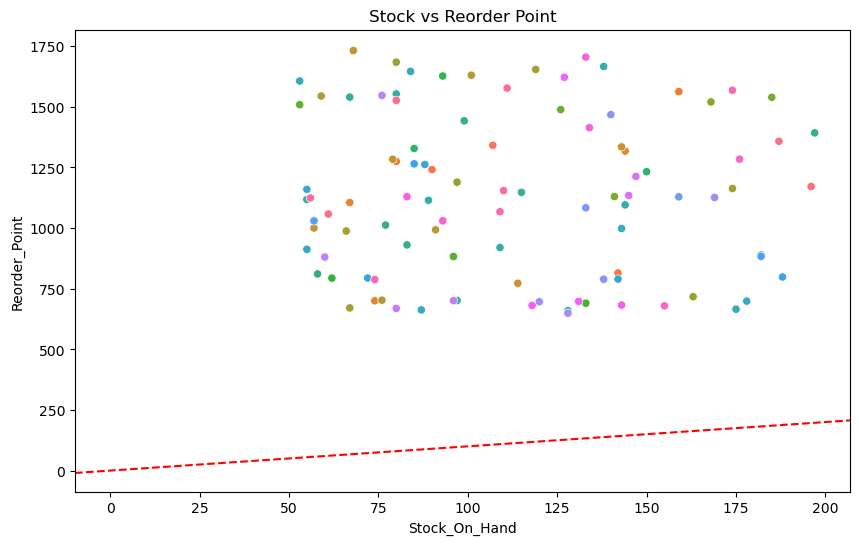

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sales = pd.read_csv("C:\\Users\\Hp\\Downloads\\data\\sales.csv", parse_dates=['Date'])
inventory = pd.read_csv("C:\\Users\\Hp\\Downloads\\data\\inventory.csv")
supplier = pd.read_csv("C:\\Users\\Hp\\Downloads\\data\\supplier.csv")

# Weekly aggregation
sales['Week'] = sales['Date'].dt.to_period('W')
weekly_sales = sales.groupby(['SKU','Week'])['Units_Sold'].sum().reset_index()

# Forecast demand using rolling average
forecast = weekly_sales.groupby('SKU')['Units_Sold'].apply(lambda x: x.rolling(4, min_periods=1).mean().iloc[-1]).reset_index()
forecast.rename(columns={'Units_Sold':'Forecast_Weekly_Sales'}, inplace=True)

# Safety stock & reorder point
lead_time = inventory.set_index('SKU')['Lead_Time_Days'].to_dict()
std_demand = weekly_sales.groupby('SKU')['Units_Sold'].std()
avg_daily_demand = weekly_sales.groupby('SKU')['Units_Sold'].mean() / 7
Z = 1.65
inventory['Safety_Stock'] = inventory['SKU'].apply(lambda x: Z * std_demand.get(x,0) * np.sqrt(lead_time.get(x,7)/7))
inventory['Reorder_Point'] = inventory['SKU'].apply(lambda x: avg_daily_demand.get(x,0)*lead_time.get(x,7) + inventory.loc[inventory['SKU']==x,'Safety_Stock'].values[0])

# Visualization
abc_counts = weekly_sales.groupby('SKU')['Units_Sold'].sum().rank(ascending=False, method='first')
abc_counts = pd.qcut(abc_counts, [0, 0.7, 0.9, 1.0], labels=['A','B','C']).value_counts()
plt.figure(figsize=(6,6))
abc_counts.plot.pie(autopct='%1.1f%%', colors=['#FF9999','#66B2FF','#99FF99'])
plt.title('ABC Classification of SKUs')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=inventory, x='Stock_On_Hand', y='Reorder_Point', hue='SKU', legend=False)
plt.axline((0,0), slope=1, color='red', linestyle='--')
plt.title('Stock vs Reorder Point')
plt.show()
